In [171]:
#load packages
import os
import time
import numpy as np
#from numpy.lib.stride_tricks import as_strided
import scipy
import scipy.signal
import xlrd
import pandas as pd
import sklearn
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import cross_val_score,RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import itertools
from itertools import combinations
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm import tqdm
import subprocess
#print(os.getcwd())
from pack import peakutils#(Package from MIT lab)
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
#Define load data
def load_data(start,end):
    df = None
    df_res = None
    df_edar = None
    df_edal = None
    
    for i in range (start,end):
        link = 'F:\\UCL\\DT\\stress_data\\BVP_RES_DATA'+ '\\'+str(i)+'.xlsx'
        locals()['data'+str(i)] = pd.read_excel(link)
        #set labels
        data = locals()['data'+str(i)]
        locals()['re_1_'+str(i)] = pd.DataFrame(data.iloc[1:,3]).T
        locals()['re_1_'+str(i)]['Label'] = 'relax'
        locals()['math_e_'+str(i)] = pd.DataFrame(data.iloc[1:,6]).T
        locals()['math_e_'+str(i)]['Label']='math_easy'
        locals()['re_3_'+str(i)] = pd.DataFrame(data.iloc[1:,9]).T
        locals()['re_3_'+str(i)]['Label'] = 'relax'
        locals()['math_h_'+str(i)] = pd.DataFrame(data.iloc[1:,12]).T
        locals()['math_h_'+str(i)]['Label'] = 'math_hard'
        locals()['re_5_'+str(i)] = pd.DataFrame(data.iloc[1:,15]).T
        locals()['re_5_'+str(i)]['Label'] = 'relax'
        #re_math_e1.index=['']
        df = pd.concat((df,locals()['re_1_'+str(i)],locals()['math_e_'+str(i)],locals()['re_3_'+str(i)],locals()['math_h_'+str(i)],
                         locals()['re_5_'+str(i)]),axis=0,ignore_index=True)   
    #Respiration
        locals()['respi_1_'+str(i)] = pd.DataFrame(data.iloc[1:,4]).T
        locals()['respi_1_'+str(i)]['Label'] = 'relax'
        locals()['respi_me_'+str(i)] = pd.DataFrame(data.iloc[1:,7]).T
        locals()['respi_me_'+str(i)]['Label']='math_easy'
        locals()['respi_3_'+str(i)] = pd.DataFrame(data.iloc[1:,10]).T
        locals()['respi_3_'+str(i)]['Label'] = 'relax'
        locals()['respi_mh_'+str(i)] = pd.DataFrame(data.iloc[1:,13]).T
        locals()['respi_mh_'+str(i)]['Label'] = 'math_hard'
        locals()['respi_5_'+str(i)] = pd.DataFrame(data.iloc[1:,16]).T
        locals()['respi_5_'+str(i)]['Label'] = 'relax'
        df_res = pd.concat((df_res,locals()['respi_1_'+str(i)],locals()['respi_me_'+str(i)],locals()['respi_3_'+str(i)],
                             locals()['respi_mh_'+str(i)],locals()['respi_5_'+str(i)]),axis=0,ignore_index=True)  

    #Right EDA
        locals()['EDA_R_1_'+str(i)] = pd.DataFrame(data.iloc[1:,19]).T
        locals()['EDA_R_1_'+str(i)]['Label'] = 'relax'
        locals()['EDA_R_me_'+str(i)] = pd.DataFrame(data.iloc[1:,21]).T
        locals()['EDA_R_me_'+str(i)]['Label']='math_easy'
        locals()['EDA_R_3_'+str(i)] = pd.DataFrame(data.iloc[1:,23]).T
        locals()['EDA_R_3_'+str(i)]['Label'] = 'relax'
        locals()['EDA_R_mh_'+str(i)] = pd.DataFrame(data.iloc[1:,25]).T
        locals()['EDA_R_mh_'+str(i)]['Label'] = 'math_hard'
        locals()['EDA_R_5_'+str(i)] = pd.DataFrame(data.iloc[1:,27]).T
        locals()['EDA_R_5_'+str(i)]['Label'] = 'relax'
        df_edar = pd.concat((df_edar,locals()['EDA_R_1_'+str(i)],locals()['EDA_R_me_'+str(i)],locals()['EDA_R_3_'+str(i)],
                              locals()['EDA_R_mh_'+str(i)],locals()['EDA_R_5_'+str(i)]),axis=0,ignore_index=True)
    #Left EDA
        locals()['EDA_L_1_'+str(i)] = pd.DataFrame(data.iloc[1:,29]).T
        locals()['EDA_L_1_'+str(i)]['Label'] = 'relax'
        locals()['EDA_L_me_'+str(i)] = pd.DataFrame(data.iloc[1:,31]).T
        locals()['EDA_L_me_'+str(i)]['Label']='math_easy'
        locals()['EDA_L_3_'+str(i)] = pd.DataFrame(data.iloc[1:,33]).T
        locals()['EDA_L_3_'+str(i)]['Label'] = 'relax'
        locals()['EDA_L_mh_'+str(i)] = pd.DataFrame(data.iloc[1:,35]).T
        locals()['EDA_L_mh_'+str(i)]['Label'] = 'math_hard'
        locals()['EDA_L_5_'+str(i)] = pd.DataFrame(data.iloc[1:,37]).T
        locals()['EDA_L_5_'+str(i)]['Label'] = 'relax'
        df_edal = pd.concat((df_edal,locals()['EDA_L_1_'+str(i)],locals()['EDA_L_me_'+str(i)],locals()['EDA_L_3_'+str(i)],
                              locals()['EDA_L_mh_'+str(i)],locals()['EDA_L_5_'+str(i)]),axis=0,ignore_index=True)
        
    return df,df_res,df_edar,df_edal

In [3]:
#Load data
start = time.clock()

df1_BVP,df1_res,df1_edar,df1_edal = load_data(1,7)
df2_BVP,df2_res,df2_edar,df2_edal = load_data(8,11)
df3_BVP,df3_res,df3_edar,df3_edal = load_data(16,24)

df_BVP = pd.concat((df1_BVP,df2_BVP,df3_BVP),axis=0,ignore_index=True)
df_Res = pd.concat((df1_res,df2_res,df3_res),axis=0,ignore_index=True)
df_EDAR = pd.concat((df1_edar,df2_edar,df3_edar),axis=0,ignore_index=True)
df_EDAL = pd.concat((df1_edal,df2_edal,df3_edal),axis=0,ignore_index=True)

elapsed = (time.clock() - start)
print("Time used:",elapsed)

Time used: 2349.047635301568


In [6]:
# df_RES_data =df_Res.iloc[:,0:71609]
# df_RES_label = df_Res.iloc[:,-1]
# df_RES = pd.concat((df_RES_data,df_RES_label),axis=1)
# df_RES.to_csv("F:\\UCL\\DT\\res_concat.csv")

In [4]:
df_BVP.head()
df_Res.head()
df_EDAR.head()
df_EDAL.head()

,1,2,3,4,5,6,7,8,9,10,...,84990,84991,84992,84993,84994,84995,84996,84997,84998,Label
0,0.011527,0.012808,0.012808,0.011527,0.014089,0.012808,0.012808,0.012808,0.012808,0.010246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,relax
1,0.012808,0.012808,0.014089,0.012808,0.01665,0.012808,0.015369,0.014089,0.015369,0.012808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,math_easy
2,0.01665,0.019212,0.015369,0.01665,0.01665,0.01665,0.01665,0.017931,0.01665,0.01665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,relax
3,0.024335,0.025616,0.024335,0.015369,0.021773,0.021773,0.024335,0.024335,0.025616,0.025616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,math_hard
4,0.023054,0.030739,0.033301,0.037143,0.035862,0.03202,0.037143,0.034581,0.023054,0.043547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,relax


In [8]:
#find the minimum length of BVP and respiration
start = time.clock()
zero_list = []
for indexs in df_BVP.index:
    for  i in range(len(df_BVP.loc[indexs].values)):
        if(df_BVP.loc[indexs].values[i] == 0):
            #print(indexs,i)
            zero_list.append(i)
            break
min_length1 = np.min(zero_list)
print(min_length1)

elapsed = (time.clock() - start)
print("Time used:",elapsed)

F:\Anocanda\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


71609


F:\Anocanda\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]


Time used: 622.4636640429999


In [11]:
#find the minimum length of edar and edal
start = time.clock()
zero_list = []

for indexs in df_EDAR.index:
    for  i in range(len(df_EDAR.loc[indexs].values)):
        if(df_EDAR.loc[indexs].values[i] ==0):
            #print(indexs,i)
            zero_list.append(i)
            break
min_length2 = np.min(zero_list)
print(min_length2)

elapsed = (time.clock() - start)
print("Time used:",elapsed)

F:\Anocanda\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


1137


F:\Anocanda\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Time used: 9.669871403999423


In [60]:
# train_data=pd.read_csv("F:\\UCL\\DT\\data.csv",sep=",")
# label_data=pd.read_csv("F:\\UCL\\DT\\test.csv",sep=",")

In [5]:
#process to the same length
df_BVP_data = df_BVP.iloc[:,0:71609]
df_BVP_label = df_BVP.iloc[:,-1]
df_BVP = pd.concat((df_BVP_data,df_BVP_label),axis=1)

df_RES_data =df_Res.iloc[:,0:71609]
df_RES_label = df_Res.iloc[:,-1]
df_RES = pd.concat((df_RES_data,df_RES_label),axis=1)

df_EDAR_data = df_EDAR.iloc[:,0:1137]
df_EDAR_label = df_EDAR.iloc[:,-1]
df_EDAR = pd.concat((df_EDAR_data,df_EDAR_label),axis=1)

df_EDAL_data = df_EDAL.iloc[:,0:1137]
df_EDAL_label = df_EDAL.iloc[:,-1]
df_EDAL = pd.concat((df_EDAL_data,df_EDAL_label),axis=1)

df_BVP.head()
df_RES.head()
df_EDAR.head()
df_EDAL.head()

,1,2,3,4,5,6,7,8,9,10,...,1129,1130,1131,1132,1133,1134,1135,1136,1137,Label
0,0.011527,0.012808,0.012808,0.011527,0.014089,0.012808,0.012808,0.012808,0.012808,0.010246,...,0.012808,0.012808,0.012808,0.011527,0.014089,0.012808,0.012808,0.012808,0.011527,relax
1,0.012808,0.012808,0.014089,0.012808,0.01665,0.012808,0.015369,0.014089,0.015369,0.012808,...,0.023054,0.029458,0.025616,0.024335,0.025616,0.025616,0.026897,0.026897,0.023054,math_easy
2,0.01665,0.019212,0.015369,0.01665,0.01665,0.01665,0.01665,0.017931,0.01665,0.01665,...,0.014089,0.015369,0.014089,0.012808,0.015369,0.014089,0.015369,0.015369,0.014089,relax
3,0.024335,0.025616,0.024335,0.015369,0.021773,0.021773,0.024335,0.024335,0.025616,0.025616,...,0.015369,0.015369,0.014089,0.014089,0.014089,0.012808,0.014089,0.012808,0.014089,math_hard
4,0.023054,0.030739,0.033301,0.037143,0.035862,0.03202,0.037143,0.034581,0.023054,0.043547,...,0.01665,0.01665,0.01665,0.01665,0.01665,0.015369,0.015369,0.01665,0.015369,relax


In [10]:
#Save Data
df_BVP.to_csv("df_BVP.csv")
df_RES.to_csv("df_RES.csv")
df_EDAR.to_csv("df_EDAR.csv")
df_EDAL.to_csv("df_EDAL.csv")

In [6]:
def smooth(a,WSZ):#WSZ must be odd number
    out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ    
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    return np.concatenate((start,out0,stop))

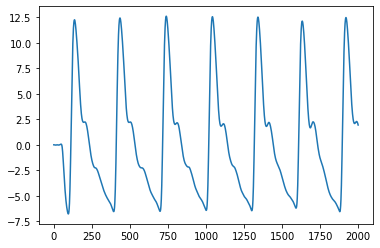

In [11]:
#test smooth data
framerate=256
x = df_BVP_data.iloc[0]- smooth(df_BVP_data.iloc[0],round(framerate+0.01)+1)
x = np.array(x)
plt.plot(x[0:2000])
plt.show()

In [12]:
#Define overlap sliding  windows 
def overlap_windows(data,overlap_rate,window_size):
    window_list = []
    start = 0
    end = window_size
    remain_length = len(data)
    
    while remain_length>=window_size:
        window_list.append(data[int(round(start+0.01)):int(round(end+0.01))])
        start += overlap_rate*window_size
        end += overlap_rate*window_size
        remain_length -= overlap_rate*window_size 
    return window_list

In [9]:
#def IBI signal
def compute_IBI(BVP, framerate):    
    x = BVP-smooth(BVP,round(framerate+0.01)+1)
    x = np.array(x)
    locs = peakutils.indexes(x, thres=0.2, min_dist=50)#
    IBI = np.diff(locs)
    return locs,IBI

In [13]:
start = time.clock()
overlap_rate = 0.5
window_size = 256*120
framerate = 256
IBI_list = []
locs_list = []
for i in range(len(df_BVP)):
    BVP = df_BVP_data.iloc[i]
    BVP_list = overlap_windows(np.array(BVP),overlap_rate,window_size)
    for j in range(len(BVP_list)):
        locs,IBI = compute_IBI(BVP_list[j],framerate)
        locs_list.append(locs)
        IBI_list.append(IBI)        
elapsed = (time.clock() - start)
print("Time used:",elapsed)

Time used: 89.28160875266076


In [15]:
#IBI length 255
IBI_list_pd = pd.DataFrame(IBI_list)
locs_list_pd = pd.DataFrame(locs_list)
IBI_list_pd.head()
locs_list_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,384,385,386,387,388,389,390,391,392,393
0,48,136,204,435,502,578,739,810,1042,1114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26,90,162,374,445,660,731,944,1017,1228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,72,175,251,450,527,650,719,799,982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29,106,374,646,919,1197,1477,1753,2030,2302,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,124,384,645,699,906,1169,1441,1504,1713,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#HRV matrix 
def compute_HRV(IBI):#,locs):
    epsilon = 0.007
    LF_band = [0.04, 0.15]# Low-frequency band
    HF_band = [0.15, 0.4]#High-frequency band (unit: hz)
    pp50_variable =0.05
    
    #LF
    freq,PERIODOGRAM = scipy.signal.periodogram(IBI)#,window = locs[1:len(locs)])
    index_1 = [i for i in range(len(freq)) if np.abs(freq[i]-LF_band[0])<epsilon]
    target_1 = np.min(index_1)-1
    index_2 = [i for i in range(len(freq)) if np.abs(freq[i]-LF_band[1])<epsilon]
    target_2 = np.min(index_2)
    LF=np.abs(np.sum(PERIODOGRAM[target_1:target_2]))
   
    #HF      
    index_3 = [i for i in range(len(freq)) if np.abs(freq[i]-HF_band[0])<epsilon]
    target_3 = np.min(index_3)-1
    index_4 = [i for i in range(len(freq)) if np.abs(freq[i]-HF_band[1])<epsilon]
    target_4 = np.min(index_4)
    HF=np.abs(np.sum(PERIODOGRAM[target_3:target_4]))         
    
    #Others
    LFHF=LF/HF
    SDPP=np.std(IBI)
    diff_IBI= np.diff(IBI)
    
    RMSSD=np.sqrt(np.mean(diff_IBI))
    b=[val for val in diff_IBI if val > pp50_variable]
    pPP50=len(b)/len(IBI)
    return LF,HF,LFHF,SDPP,RMSSD,pPP50   

In [17]:
#compute HRV matrix with sliding windows data
LF_list = []
HF_list = []
LFHF_list = []
SDPP_list = []
RMSSD_list = []
pPP50_list = []
for i in range(len(IBI_list)):
    LF,HF,LFHF,SDPP,RMSSD,pPP50 = compute_HRV(IBI_list[i])
    LF_list.append(LF)
    HF_list.append(HF)
    LFHF_list.append(LFHF)
    SDPP_list.append(SDPP)
    RMSSD_list.append(RMSSD)
    pPP50_list.append(pPP50)
step = int(len(IBI_list)/len(df_BVP))
LF_list = [LF_list[i:i+step] for i in range(0,len(LF_list),step)]
HF_list = [HF_list[i:i+step] for i in range(0,len(HF_list),step)]
LFHF_list = [LFHF_list[i:i+step] for i in range(0,len(LFHF_list),step)]
SDPP_list = [SDPP_list[i:i+step] for i in range(0,len(SDPP_list),step)]
RMSSD_list= [RMSSD_list[i:i+step] for i in range(0,len(RMSSD_list),step)]
pPP50_list = [pPP50_list[i:i+step] for i in range(0,len(pPP50_list),step)]

F:\Anocanda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


In [18]:
LF_list = pd.DataFrame(LF_list)
HF_list = pd.DataFrame(HF_list)
LFHF_list = pd.DataFrame(LFHF_list) 
SDPP_list = pd.DataFrame(SDPP_list)  
pPP50_list = pd.DataFrame(pPP50_list)
RMSSD_list = pd.DataFrame(RMSSD_list)#negative number
LF_list.head()

,0,1,2
0,16006.062293,10057.679155,12358.886259
1,117259.503896,122576.092913,152012.249641
2,178997.906331,120705.454937,89064.245120
3,22645.930250,38425.765734,85279.384853
4,353397.655942,190783.034387,135970.608698


In [19]:
#define sliding statistical feature from sliding window
def compute_statistical_feature(arr):
    mean_list = []
    range_list = []
    max_list = []
    min_list = []
    medium_list = []
    sum_list = []
    std_list = []
    for i in range(len(arr)):
        mean_list.append(np.mean(arr[i]))
        max_list.append(np.max(arr[i]))
        min_list.append(np.min(arr[i]))
        medium_list.append(np.median(arr[i]))
        sum_list.append(np.sum(arr[i]))
        std_list.append(np.std(arr[i]))
        range_list.append(np.max(arr[i])-np.min(arr[i]))
    return mean_list,max_list,min_list,medium_list,sum_list,std_list,range_list

In [20]:
#Compute respiration statistical features with overlap sliding windows
overlap_rate = 0.5
window_size = 256*120
mean_res = []
max_res = []
min_res = []
medium_res = []
sum_res = []
std_res = []
range_res = []

for i in range(len(df_RES_data)):
    locals()['window_res_'+str(i)] = overlap_windows(np.array(df_RES_data.iloc[i]),overlap_rate,window_size)
    mean_list,max_list,min_list,medium_list,sum_list,std_list,range_list = compute_statistical_feature( locals()['window_res_'+str(i)])
    mean_res.append(mean_list)
    max_res.append(max_list)
    min_res.append(min_list)
    medium_res.append(medium_list)
    sum_res.append(sum_list)
    std_res.append(std_list)
    range_res.append(range_list)

mean_res = pd.DataFrame(mean_res)
max_res = pd.DataFrame(max_res)
min_res = pd.DataFrame(min_res)
medium_res = pd.DataFrame(medium_res)
sum_res = pd.DataFrame(sum_res)
std_res = pd.DataFrame(std_res)
range_res = pd.DataFrame(range_res)

In [79]:
#report 
res_feature = pd.concat((pd.DataFrame(mean_res.iloc[:,0]),pd.DataFrame(max_res.iloc[:,0]),pd.DataFrame(min_res.iloc[:,0]),
                         pd.DataFrame(medium_res.iloc[:,0]),pd.DataFrame(sum_res.iloc[:,0]),pd.DataFrame(std_res.iloc[:,0]),
                         pd.DataFrame(range_res.iloc[:,0])),axis=1,ignore_index=True)
res_feature.head()

,0,1,2,3,4,5,6
0,23.476689,28.224,21.827,23.153,721203.876,1.118912,6.397
1,22.397991,26.075,18.561,22.507,688066.291,1.351270,7.514
2,23.707224,27.071,22.470,23.506,728285.911,0.898053,4.601
3,22.124185,25.831,19.810,22.082,679654.966,0.938708,6.021
4,21.746733,25.274,20.731,21.469,668059.642,0.841671,4.543


In [91]:
#Define compute GSR(EDA) features
import biosppy.signals
from biosppy.signals import eda
def feature_GSR(data):
    ts,filtered,onsets,peaks,amplitudes = biosppy.signals.eda.eda(data,sampling_rate = 16.0,show=False)
    #average SCR amplitude mean
    amplitude_mean = np.mean(np.array(amplitudes))
    #Number of SCR
    scr_number = len(amplitudes)
    #Mean skin conductance
    msc = np.mean(np.array(filtered))
    #mean rise time of SCR
    rt = []
    for i in range(len(onsets)):
        diff = peaks[i]-onsets[i]
        rt.append(diff)
    rtm = np.mean(np.array(rt)) 
    return amplitude_mean,scr_number,msc,rtm

In [27]:
#Compute GSR(EDA) features
#right
amplitude_mean_rlist = []
scr_rlist = []
msc_rlist = []
rtm_rlist = []
for i in range(len(df_EDAR)):
    amplitude_mean,scr,msc,rtm = feature_GSR(np.array(df_EDAR_data.iloc[i]))
    amplitude_mean_rlist.append(amplitude_mean)
    scr_rlist.append(scr)
    msc_rlist.append(msc)
    rtm_rlist.append(rtm)
    
#left
amplitude_mean_llist = []
scr_llist = []
msc_llist = []
rtm_llist = []
for i in range(len(df_EDAL)):
    amplitude_mean,scr,msc,rtm = feature_GSR(np.array(df_EDAL_data.iloc[i]))
    amplitude_mean_llist.append(amplitude_mean)
    scr_llist.append(scr)
    msc_llist.append(msc)
    rtm_llist.append(rtm)

F:\Anocanda\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
F:\Anocanda\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [32]:
#
amplitude_mean_rlist = pd.DataFrame(amplitude_mean_rlist)
scr_rlist = pd.DataFrame(scr_rlist)
msc_rlist = pd.DataFrame(msc_rlist)
rtm_rlist = pd.DataFrame(rtm_rlist)
#
amplitude_mean_llist = pd.DataFrame(amplitude_mean_llist)
scr_llist = pd.DataFrame(scr_llist)
msc_llist = pd.DataFrame(msc_llist)
rtm_llist = pd.DataFrame(rtm_llist)
#
GSR_data = pd.concat((amplitude_mean_rlist,scr_rlist,msc_rlist,rtm_rlist,amplitude_mean_llist,scr_llist,msc_llist,rtm_llist),
                     axis = 1 ,ignore_index=True)

In [34]:
GSR_data.head()

,0,1,2,3,4,5,6,7
0,0.004715,19,9.121011,15.421053,0.000031,33,0.013124,10.363636
1,0.027349,18,13.710342,16.111111,0.000355,15,0.018756,13.600000
2,0.015218,13,14.064204,17.307692,0.000236,10,0.017062,14.200000
3,0.031469,8,27.638334,13.250000,0.000172,8,0.015348,10.250000
4,0.003306,1,17.735503,3.000000,0.000085,4,0.015231,24.500000


In [113]:
#Define Openface feature extraction
def Openface_AU(start,end):
    exe_dir = "F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\"

    for i in range(start,end):
        file_dir = "F:\\UCL\\DT\\stress_data\\video\\P"+str(i)+"\\"

        if __name__ == '__main__':
            command = [exe_dir+ "FeatureExtraction" + (".exe" if os.name == "nt" else "")]
            for filename in tqdm(glob(os.path.join(file_dir, '*.avi'))):
                command.append('-f')
                command.append(filename)
            print(command)
            subprocess.call(command)

In [177]:
#do not need to run again
Openface_AU(1,11)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P1\\1_R1Time0101P1.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P1\\2_METime0854P1.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P1\\3_R3Time1528P1.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P1\\4_MHTime2302P1.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P1\\5_R5Time2938P1.avi']


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5003.94it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P2\\1_R1Time0034P2.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P2\\2_MHTime0901P2.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P2\\3_R3Time1530P2.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P2\\4_METime2229P2.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P2\\5_R5Time2831P2.avi']


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5032.76it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P3\\1_R1Time0039P3.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P3\\2_METime1022P3.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P3\\3_R3Time1620P3.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P3\\4_MHTime2316P3.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P3\\5_R5Time2954P3.avi']


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2498.99it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P4\\1_R1Time0116P4.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P4\\2_MHTime0801P4.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P4\\3_R3Time1624P4.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P4\\4_METime2320P4.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P4\\5_R5Time3103P4.avi']


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5032.76it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P5\\1_R1Time0058P5.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P5\\2_METime0947P5.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P5\\3_R3Time1608P5.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P5\\4_MHTime2248P5.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P5\\5_R5Time2926P5.avi']


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P6\\1_R1Time0154P6.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P6\\2_MHTime1128P6.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P6\\3_R3Time1809P6.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P6\\4_METime2607P6.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P6\\5_R5Time3251P6.avi']


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5196.11it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P7\\1_R1Time0103P7.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P7\\2_METime0746P7.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P7\\3_R3Time1344P7.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P7\\4_MHTime2030P7.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P7\\5_R5Time2630P7.avi']


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5007.53it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P8\\1_R1Time0358P8.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P8\\2_MHTime1207P8.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P8\\3_R3Time1855P8.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P8\\4_METime2700P8.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P8\\5_R5Time3404P8.avi']


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5030.35it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P9\\1_R1Time0137P9.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P9\\2_METime1030P9.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P9\\3_R3Time1645P9.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P9\\4_MHTime2320P9.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P9\\5_R5Time2917P9.avi']


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P10\\1_R1Time0049P10.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P10\\2_MHTime0734P10.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P10\\3_R3Time1326P10.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P10\\4_METime2121P10.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P10\\5_R5Time2739P10.avi']


In [178]:
Openface_AU(14,24)

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5023.12it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P14\\1_R1Time0112P14.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P14\\2_MHTime0935P14.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P14\\3_R3Time1624P14.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P14\\4_METime2400P14.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P14\\5_R5Time3020P14.avi']


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P15\\1_R1Time0140P15.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P15\\2_METime0815P15.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P15\\3_R3Time1523P15.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P15\\4_MHTime2358P15.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P15\\5_R5Time3049P15.avi']


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 4466.78it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P16\\1_R1Time0055P16.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P16\\2_MHTime1010P16.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P16\\3_R3Time1647P16.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P16\\4_METime2420P16.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P16\\5_R5Time3019P16.avi']


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3495.25it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P17\\1_R1Time0117P17.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P17\\2_METime0905P17.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P17\\3_R3Time1556P17.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P17\\4_MHTime2333P17.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P17\\5_R5Time3009P17.avi']


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5079.08it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P18\\1_R1Time0121P18.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P18\\2_MHTime0824P18.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P18\\3_R3Time1545P18.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P18\\4_METime2240P18.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P18\\5_R5Time2836P18.avi']


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2516.38it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P19\\1_R1Time0047P19.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P19\\2_METime0725P19.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P19\\3_R3Time1337P19.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P19\\4_MHTime2030P19.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P19\\5_R5Time2630P19.avi']


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 4999.17it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P20\\1_R1Time0129P20.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P20\\2_MHTime0900P20.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P20\\3_R3Time1508P20.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P20\\4_METime2148P20.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P20\\5_R5Time2740P20.avi']


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5043.66it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P21\\1_R1Time0040P21.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P21\\2_METime0800P21.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P21\\3_R3Time1443P21.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P21\\4_MHTime2229P21.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P21\\5_R5Time2858P21.avi']


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P22\\1_R1Time0035P22.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P22\\2_MHTime0833P22.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P22\\3_R3Time1445P22.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P22\\4_METime2130P22.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P22\\5_R5Time2808P22.avi']


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2507.66it/s]


['F:\\UCL\\DT\\stress_data\\video\\OpenFace_2.2.0_win_x64\\FeatureExtraction.exe', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P23\\1_R1Time0135P23.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P23\\2_METime0931P23.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P23\\3_R3Time1652P23.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P23\\4_MHTime2415P23.avi', '-f', 'F:\\UCL\\DT\\stress_data\\video\\P23\\5_R5Time3154P23.avi']


In [114]:
# #AUs statistical feature extraction, the method to extract another features are in sigle_facial_model
def AU_features(start,end):
    all_person_au = None
    for i in range(start,end+1):
        name = "*p"+str(i)+".csv"
        file_dir = "F:\\UCL\\DT\\processed"
        one_person_au = None
        for filename in glob(os.path.join(file_dir, name)):
            data = pd.read_csv(filename,sep=",")
            a = pd.DataFrame(data.iloc[:,682])
            b = pd.DataFrame(data.iloc[:,685])
            c = pd.DataFrame(data.iloc[:,687])
            AU = pd.concat((a,b,c),axis=1,ignore_index=True)
            AU_mean = pd.DataFrame(np.mean(AU)).T
            AU_std = pd.DataFrame(np.std(AU)).T
            AU_max = pd.DataFrame(np.max(AU)).T
            AU_min = pd.DataFrame(np.min(AU)).T
            #AU_medium = pd.DataFrame(np.median(AU)).T
            AU_sta = pd.concat((AU_mean,AU_std,AU_max,AU_min),axis=1,ignore_index=True)
            one_person_au = pd.concat((one_person_au,AU_sta),axis=0,ignore_index=True)
        all_person_au = pd.concat((all_person_au,one_person_au),axis=0,ignore_index=True)  
    return all_person_au        

In [37]:
#the method to extract another features are in sigle_facial_model
data1 = pd.read_csv("F:\\UCL\\DT\\set1_AUsingle.csv")
data2 = pd.read_csv("F:\\UCL\\DT\\set2_AUsingle.csv")
data3 = pd.read_csv("F:\\UCL\\DT\\set3_AUsingle.csv")
Facial_data = pd.concat((data1,data2,data3),axis=0,ignore_index =True)
Facial_data = Facial_data.iloc[:,1:]
Facial_data.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,71.307692,2.010198,2.783999,65.880952,3.965875,5.028372,69.775000,-14.733613,-5.166552,64.674419,...,0.001401,0.115236,0.036181,0.005987,0.92,0.30,0.07,0.0,0.0,0.0
1,74.648649,0.665547,1.221186,74.189189,3.022972,4.197288,72.842105,-0.117260,11.197088,70.815789,...,0.002734,0.234579,0.071577,0.009344,1.65,0.52,0.17,0.0,0.0,0.0
2,72.736842,0.545162,1.397604,71.282051,1.643939,2.854263,73.105263,7.572508,18.502466,70.846154,...,0.006741,0.147695,0.038351,0.015736,1.31,0.32,0.17,0.0,0.0,0.0
3,75.108108,2.060761,3.565752,71.461538,1.154526,2.902383,74.162162,6.470796,14.040436,77.166667,...,0.353955,0.129553,0.060566,0.174563,1.10,0.76,1.56,0.0,0.0,0.0
4,64.697674,0.628926,1.588974,72.000000,0.546210,2.107824,70.410256,10.822982,23.815832,67.829268,...,0.004744,0.194951,0.048023,0.013877,1.96,0.47,0.31,0.0,0.0,0.0


In [115]:
# start = time.clock()

# set_1 = AU_features(1,6)
# set_2 = AU_features(8,10)
# set_3 = AU_features(16,23)
# Final_AU = pd.concat((set_1,set_2,set_3),axis=0,ignore_index=True)
# Final_AU.head()

# end = time.clock()
# print(str(end-start))

F:\Anocanda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
F:\Anocanda\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


491.4110193649976


In [116]:
#concat au statistical features
# Final_AU = pd.concat((set_1,set_2,set_3),axis=0,ignore_index=True)
# Final_AU.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.051939,0.028534,0.001401,0.115236,0.036181,0.005987,0.92,0.30,0.07,0.0,0.0,0.0
1,0.090960,0.041288,0.002734,0.234579,0.071577,0.009344,1.65,0.52,0.17,0.0,0.0,0.0
2,0.064484,0.028963,0.006741,0.147695,0.038351,0.015736,1.31,0.32,0.17,0.0,0.0,0.0
3,0.061315,0.039365,0.353955,0.129553,0.060566,0.174563,1.10,0.76,1.56,0.0,0.0,0.0
4,0.065556,0.033432,0.004744,0.194951,0.048023,0.013877,1.96,0.47,0.31,0.0,0.0,0.0


In [38]:
#Data fusion for four modality
Final_data = pd.concat((mean_res,max_res,min_res,medium_res,sum_res,std_res,range_res,
                       LF_list,HF_list,LFHF_list,SDPP_list,pPP50_list,RMSSD_list,
                       GSR_data, Facial_data),axis=1,ignore_index=True)

Final_data = Final_data.fillna(0)
Final_data.head()

#Scale all feature data
Final_data_scaled = Final_data.copy()
scaler = StandardScaler().fit(Final_data_scaled)                   
Final_data_scaled = scaler.transform(Final_data_scaled)
Final_data_scaled = pd.DataFrame(Final_data_scaled)
Final_data_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,23.476689,23.774978,23.792988,28.224,28.450,28.450,21.827,22.359,22.284,23.153,...,0.001401,0.115236,0.036181,0.005987,0.92,0.30,0.07,0.0,0.0,0.0
1,22.397991,22.989700,22.981177,26.075,25.758,26.563,18.561,21.356,21.164,22.507,...,0.002734,0.234579,0.071577,0.009344,1.65,0.52,0.17,0.0,0.0,0.0
2,23.707224,23.697090,23.504083,27.071,27.071,26.048,22.470,22.381,22.159,23.506,...,0.006741,0.147695,0.038351,0.015736,1.31,0.32,0.17,0.0,0.0,0.0
3,22.124185,22.767305,23.355331,25.831,27.005,29.241,19.810,20.749,21.840,22.082,...,0.353955,0.129553,0.060566,0.174563,1.10,0.76,1.56,0.0,0.0,0.0
4,21.746733,21.448262,21.319702,25.274,25.204,27.937,20.731,20.049,20.049,21.469,...,0.004744,0.194951,0.048023,0.013877,1.96,0.47,0.31,0.0,0.0,0.0


In [108]:
#respiration and facial only
Final_data1 = pd.concat((mean_res,max_res,min_res,medium_res,sum_res,std_res,range_res,
                        Facial_data),axis=1,ignore_index=True)

Final_data1 = Final_data1.fillna(0)
Final_data_scaled1 = Final_data1.copy()
scaler = StandardScaler().fit(Final_data_scaled1)                   
Final_data_scaled1 = scaler.transform(Final_data_scaled1)
Final_data_scaled1= pd.DataFrame(Final_data_scaled1)
Final_data_scaled1.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.813891,-0.801824,-0.813456,-0.758378,-0.742860,-0.801030,-0.632630,-0.740013,-0.786777,-0.833641,...,-0.617826,0.315427,-0.825637,-0.757397,-0.261078,-0.731054,-0.882220,0.0,0.0,-0.23173
1,-0.936612,-0.891298,-0.905985,-0.992087,-1.035724,-1.008728,-0.989414,-0.853283,-0.913901,-0.907286,...,-0.612447,2.713362,-0.032181,-0.734148,0.867833,-0.259650,-0.788811,0.0,0.0,-0.23173
2,-0.787663,-0.810699,-0.846385,-0.883770,-0.892882,-1.065413,-0.562388,-0.737528,-0.800965,-0.793398,...,-0.596278,0.967621,-0.776984,-0.689864,0.342039,-0.688199,-0.788811,0.0,0.0,-0.23173
3,-0.967763,-0.916638,-0.863339,-1.018623,-0.900062,-0.713967,-0.852971,-0.921833,-0.837173,-0.955736,...,0.804945,0.603088,-0.279003,0.410355,0.017284,0.254608,0.509573,0.0,0.0,-0.23173
4,-1.010705,-1.066928,-1.095358,-1.079198,-1.095994,-0.857495,-0.752359,-1.000885,-1.040456,-1.025619,...,-0.604334,1.917134,-0.560184,-0.702745,1.347234,-0.366787,-0.658038,0.0,0.0,-0.23173


In [117]:
#BVP and GSR only
Final_data2 = pd.concat((LF_list,HF_list,LFHF_list,SDPP_list,pPP50_list,RMSSD_list,
                        GSR_data),axis=1,ignore_index=True)

Final_data2 = Final_data2.fillna(0)
Final_data_scaled2 = Final_data2.copy()
scaler = StandardScaler().fit(Final_data_scaled2)                   
Final_data_scaled2 = scaler.transform(Final_data_scaled2)
Final_data_scaled2 = pd.DataFrame(Final_data_scaled2)
Final_data_scaled2.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,-1.050138,-0.918416,-0.861489,-0.737726,-0.785030,-0.727684,-1.127704,-0.593890,-0.668970,1.652998,...,1.649375,-0.150320,-0.735099,0.410166,0.192628,1.071932,-0.285839,1.170023,-0.333794,-0.395172
1,0.261416,0.529911,0.741019,0.836438,0.515907,1.700266,-0.826352,-0.443967,-0.693179,1.099995,...,-0.922768,0.605865,0.952699,0.305469,0.675413,1.252184,-0.281881,-0.378537,-0.331317,0.073975
2,1.061124,0.505832,0.018697,4.348356,4.368143,2.281717,-1.325528,-1.470402,-1.013747,2.854580,...,0.525348,2.501031,0.048055,-0.218016,0.712638,1.564745,-0.283334,-0.808692,-0.332063,0.160951
3,-0.964131,-0.553265,-0.024734,-0.968455,-0.441293,-0.282256,1.115528,-0.521393,0.088558,-0.773699,...,1.382767,0.706511,1.259893,-0.741502,2.140600,0.504827,-0.284113,-0.980754,-0.332816,-0.411645
4,3.320155,1.407864,0.556942,3.432264,2.472784,1.175633,-0.510640,-0.923055,-0.621094,2.930678,...,0.035555,0.445998,-0.840163,-1.474382,1.098849,-2.172599,-0.285181,-1.324878,-0.332868,1.654048


In [156]:
#Facial only
Final_data3 = Facial_data

Final_data3 = Final_data3.fillna(0)


Final_data_scaled3 = Final_data3.copy()
scaler = StandardScaler().fit(Final_data_scaled3)                   
Final_data_scaled3 = scaler.transform(Final_data_scaled3)
Final_data_scaled3 = pd.DataFrame(Final_data_scaled3)
Final_data_scaled3.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,-0.234839,0.552716,-0.174750,-1.865587,0.950124,0.023057,-0.312371,-1.067029,-1.441449,-2.325233,...,-0.617826,0.315427,-0.825637,-0.757397,-0.261078,-0.731054,-0.882220,0.0,0.0,-0.23173
1,0.923675,-0.172158,-0.782308,0.827907,0.633329,-0.147272,0.896650,-0.231882,-0.624580,-0.206549,...,-0.612447,2.713362,-0.032181,-0.734148,0.867833,-0.259650,-0.788811,0.0,0.0,-0.23173
2,0.260735,-0.237055,-0.713724,-0.114574,0.170003,-0.422524,1.000384,0.207495,-0.259898,-0.196074,...,-0.596278,0.967621,-0.776984,-0.689864,0.342039,-0.688199,-0.788811,0.0,0.0,-0.23173
3,1.082998,0.579973,0.129164,-0.056385,0.005571,-0.412662,1.417002,0.144546,-0.482641,1.984410,...,0.804945,0.603088,-0.279003,0.410355,0.017284,0.254608,0.509573,0.0,0.0,-0.23173
4,-2.526936,-0.191900,-0.639327,0.118181,-0.198811,-0.575506,-0.061960,0.393220,0.005344,-1.236856,...,-0.604334,1.917134,-0.560184,-0.702745,1.347234,-0.366787,-0.658038,0.0,0.0,-0.23173


In [43]:
labels = df_EDAL.iloc[:,-1]
Final_label = labels.copy()
lab = preprocessing.LabelEncoder()
lab.fit(labels)
lab.fit(Final_label.values)
labels_enc=lab.transform(Final_label)
labels3 = pd.DataFrame(labels_enc,columns=['labels'])
labels2 = labels3.replace(2,0)
labels2.head()

,labels
0,0
1,0
2,0
3,1
4,0


In [46]:
#save data and label 
labels2.to_csv("labels2.csv",index=False,sep=',')
Final_data_scaled.to_csv("scaled_data.csv",index=False,sep=',')

In [47]:
#Grid search for MLP
mlp = MLPClassifier()
gsc1 = GridSearchCV(mlp,
                   param_grid = {'activation':["identity","logistic","tanh","relu"],
                                 'solver':["lbfgs", "sgd", "adam"],
                                 'alpha':[0.5,0.25, 0.1, 0.05, 0.025, 0.01, 0.005, 0.001],
                                 'hidden_layer_sizes':[(50,50,50),(50,100,50),(100,50),(50,50),(100,)],
                                 'learning_rate_init':[0.5,0.25, 0.1, 0.05, 0.025, 0.01, 0.005, 0.001]},
                  n_jobs=-1,scoring = 'accuracy',cv=17)

grid_result = gsc1.fit(Final_data_scaled,labels2)
best_params1_2 = grid_result.best_params_
best_params1_2

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'activation': 'logistic',
 'alpha': 0.5,
 'hidden_layer_sizes': (50, 100, 50),
 'learning_rate_init': 0.1,
 'solver': 'adam'}

In [157]:
#classification model 1 MLP
evaluation_list=[]
F1 = []
Recall = []
Precision = []
#
clf1 = MLPClassifier(activation='logistic',solver='adam',learning_rate_init=0.1, alpha=0.5,hidden_layer_sizes=(50,100,50))
evaluation = cross_val_score(clf1,Final_data_scaled3,labels2,cv=17,scoring='accuracy')
f1 = cross_val_score(clf1,Final_data_scaled3,labels2,cv=17,scoring='f1_macro')
recall = cross_val_score(clf1,Final_data_scaled3,labels2,cv=17,scoring='recall_macro')
precision = cross_val_score(clf1,Final_data_scaled3,labels2,cv=17,scoring='precision_macro')
#
evaluation_list.append(['Neural network',evaluation.mean()])
F1.append(['Neural network',f1.mean()])
Recall.append(['Neural network',recall.mean()])
Precision.append([['Neural network',precision.mean()]])
#
print('Accuracy:',evaluation.mean(),'F1:',f1.mean(),'Recall:',recall.mean(),'Precision:',precision.mean())

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vecto

Accuracy: 0.8352941176470587 F1: 0.631185807656396 Recall: 0.6691176470588235 Precision: 0.6838235294117647


In [130]:
#Grid search for SVM
svc = SVC()
gsc2 = GridSearchCV(svc,
                   param_grid = {'C':[0.1, 1.0, 10.0, 100.0, 1000.0],
                                 'kernel':["poly","rbf","sigmoid"],
                                 'gamma':[0.0001, 0.001, 0.005, 0.1, 1, 3],
                                 'decision_function_shape':["ovo","ovr"],
                                 'probability':[True,False]},
                    n_jobs=-1,scoring = 'accuracy',cv=17)

grid_result = gsc2.fit(Final_data_scaled,labels2)
best_params2_2 = grid_result.best_params_
best_params2_2

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10.0,
 'decision_function_shape': 'ovo',
 'gamma': 0.005,
 'kernel': 'sigmoid',
 'probability': True}

In [158]:
#classification model 2 SVM
clf2 = SVC(C=10,decision_function_shape='ovo',gamma=0.005,kernel='sigmoid',probability=True)
#
evaluation = cross_val_score(clf2,Final_data_scaled3,labels2,cv=17,scoring='accuracy')
f1 = cross_val_score(clf2,Final_data_scaled3,labels2,cv=17,scoring='f1_macro')
recall = cross_val_score(clf2,Final_data_scaled3,labels2,cv=17,scoring='recall_macro')
precision = cross_val_score(clf2,Final_data_scaled3,labels2,cv=17,scoring='precision_macro')
#
evaluation_list.append(['SVC',evaluation.mean()])
F1.append(['SVC',f1.mean()])
Recall.append(['SVC',recall.mean()])
Precision.append([['SVC',precision.mean()]])
#
print('Accuracy:',evaluation.mean(),'F1:',f1.mean(),'Recall:',recall.mean(),'Precision:',precision.mean())

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

Accuracy: 0.8117647058823529 F1: 0.6685340802987861 Recall: 0.7279411764705882 Precision: 0.6568627450980392


In [60]:
#Grid search for KNN
knn = KNeighborsClassifier()
gsc3 = GridSearchCV(knn,
                   param_grid = {'n_neighbors':[3,5,7,11,15,19],
                                  'algorithm':["auto"],
                                 'weights':["uniform","distance"],
                                 'metric':["euclidean","manhattan"]},
                                 n_jobs = -1,scoring = 'accuracy',cv=17)

grid_result = gsc3.fit(Final_data_scaled,labels2)
best_params3_3 = grid_result.best_params_
best_params3_3

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'algorithm': 'auto',
 'metric': 'manhattan',
 'n_neighbors': 5,
 'weights': 'uniform'}

In [151]:
#classification model 3 KNN
clf3 = KNeighborsClassifier(algorithm='auto',metric='manhattan',n_neighbors=5,weights='uniform')
#
evaluation = cross_val_score(clf3,Final_data_scaled2,labels2,cv=17,scoring='accuracy')
f1 = cross_val_score(clf3,Final_data_scaled2,labels2,cv=17,scoring='f1_macro')
recall = cross_val_score(clf3,Final_data_scaled2,labels2,cv=17,scoring='recall_macro')
precision = cross_val_score(clf3,Final_data_scaled2,labels2,cv=17,scoring='precision_macro')
#
evaluation_list.append(['KNN',evaluation.mean()])
F1.append(['KNN',f1.mean()])
Recall.append(['KNN',recall.mean()])
Precision.append([['KNN',precision.mean()]])
#
print('Accuracy:',evaluation.mean(),'F1:',f1.mean(),'Recall:',recall.mean(),'Precision:',precision.mean())

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A col

Accuracy: 0.7882352941176471 F1: 0.4689542483660131 Recall: 0.5147058823529411 Precision: 0.4323529411764706


In [61]:
#Grid search for Random Forest
start = time.clock()

rf = RandomForestClassifier()
gsc4 = GridSearchCV(rf,
                   param_grid = {'n_estimators':[50,100,150,200,300,400],
                                 'bootstrap': [True, False],
                                 'max_depth':[10, 30, 50, 70, 100, 150, 200, 300, None],
                                 'max_features': ["auto","sqrt"],
                                 'min_samples_leaf': [1, 2, 3, 4, 5],
                                 'min_samples_split': [2, 4, 5, 6, 7, 8]},
                                 n_jobs = -1,scoring = 'accuracy',cv=17)

grid_result = gsc4.fit(Final_data_scaled,labels2)
best_params4_3 = grid_result.best_params_
best_params4_3

print('time used: '+str(time.clock()-start))

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


time used: 28964.427500135313


In [62]:
best_params4_3

{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 50}

In [152]:
#classification model 4 Random Forest
clf4=RandomForestClassifier(n_estimators=50, max_depth=70,min_samples_leaf=1,min_samples_split=6,bootstrap=True,max_features='sqrt')
#
evaluation = cross_val_score(clf4,Final_data_scaled2,labels2, cv=17, scoring='accuracy')
f1 = cross_val_score(clf4,Final_data_scaled2,labels2,cv=17,scoring='f1_macro')
recall = cross_val_score(clf4,Final_data_scaled2,labels2,cv=17,scoring='recall_macro')
precision = cross_val_score(clf4,Final_data_scaled2,labels2,cv=17,scoring='precision_macro')
#
evaluation_list.append(['Random_Forest',evaluation.mean()])
F1.append(['Random_Forest',f1.mean()])
Recall.append(['Random_Forest',recall.mean()])
Precision.append([['Random_Forest',precision.mean()]])
#
print('Accuracy:',evaluation.mean(),'F1:',f1.mean(),'Recall:',recall.mean(),'Precision:',precision.mean())

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column

Accuracy: 0.7882352941176471 F1: 0.4403594771241831 Recall: 0.5 Precision: 0.4


In [ ]:
#Grid search for Xgboost
xgbc = xgb.XGBClassifier()
gsc5 = GridSearchCV(xgbc,
                   param_grid = {'learning_rate':[0.01, 0.025, 0.05, 0.1, 0.25, 0.5],
                                 'max_depth': [10, 15, 20, 25, 30],
                                 'min_child_weight': [0, 2, 5, 7, 10, 15, 20],
                                'gamma':[0,0.05,0.1,0.15,0.2],
                                'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
                                'reg_lambda': [0.2, 0.4, 0.6, 0.8, 1],
                                'max_delta_step':[0, 0.2, 0.6, 1, 2]},
                                 n_jobs = -1,scoring = 'accuracy',cv=17)

grid_result = gsc5.fit(Final_data_scaled,labels2)
best_params5_3 = grid_result.best_params_
best_params5_3

In [205]:
#classification model 5 xgboost
clf5=xgb.XGBClassifier(max_depth=30,min_child_weight=15,learning_rate=0.01,gamma=0.2,reg_alpha=0.5,reg_lambda=0.6,max_delta_step=1)
#
evaluation = cross_val_score(clf5,Final_data_scaled3,labels2, cv=17, scoring='accuracy')#labels_df
f1 = cross_val_score(clf5,Final_data_scaled3,labels2,cv=17,scoring='f1_macro')
recall = cross_val_score(clf5,Final_data_scaled3,labels2,cv=17,scoring='recall_macro')
precision = cross_val_score(clf5,Final_data_scaled3,labels2,cv=17,scoring='precision_macro')
#
evaluation_list.append(['XGB-Classifier',evaluation.mean()])
F1.append(['XGB-Classifier',f1.mean()])
Recall.append(['XGB-Classifier',recall.mean()])
Precision.append([['XGB-Classifier',precision.mean()]])
#
print('Accuracy:',evaluation.mean(),'F1:',f1.mean(),'Recall:',recall.mean(),'Precision:',precision.mean())

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

Accuracy: 0.8 F1: 0.4444444444444445 Recall: 0.5 Precision: 0.4


In [66]:
#Grid search for lgb
lgb1 = lgb.LGBMClassifier()
gsc6 = GridSearchCV(lgb1,
                   param_grid = {'max_depth':[10, 15, 20, 30],
                                 'learning_rate':[0.25, 0.1, 0.05, 0.025, 0.003],
                                 'feature_fraction':[0.6,0.7,0.9,0.95],
                                 'cat_smooth':[1,10,15,20,35],
                                 'lambda_l1':[0.1,0.3,0.5,0.6],
                                 'lambda_l2':[5,10,15,20,35],
                                },
                                 n_jobs = -1,scoring = 'accuracy',cv=17)

grid_result = gsc6.fit(Final_data_scaled,labels2)
best_params6_3 = grid_result.best_params_
best_params6_3

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'cat_smooth': 1,
 'feature_fraction': 0.95,
 'lambda_l1': 0.1,
 'lambda_l2': 20,
 'learning_rate': 0.25,
 'max_depth': 10}

In [196]:
#classification model 6 Lgboost
clf6 = lgb.LGBMClassifier(max_depth=10,learning_rate = 0.25,lambda_l2=20,lambda_l1=0.1,feature_fraction=0.95,cat_smooth=1)
#
evaluation = cross_val_score(clf6,Final_data_scaled3,labels2, cv=17, scoring='accuracy')#labels_df
f1 = cross_val_score(clf6,Final_data_scaled3,labels2,cv=17,scoring='f1_macro')
recall = cross_val_score(clf6,Final_data_scaled3,labels2,cv=17,scoring='recall_macro')
precision = cross_val_score(clf6,Final_data_scaled3,labels2,cv=17,scoring='precision_macro')
#
evaluation_list.append(['LGB-Classifier',evaluation.mean()])
F1.append(['LGB-Classifier',f1.mean()])
Recall.append(['LGB-Classifier',recall.mean()])
Precision.append([['LGB-Classifier',precision.mean()]])
#
print('Accuracy:',evaluation.mean(),'F1:',f1.mean(),'Recall:',recall.mean(),'Precision:',precision.mean())

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

Accuracy: 0.8823529411764706 F1: 0.7732959850606909 Recall: 0.8161764705882353 Precision: 0.7720588235294118


In [137]:
#Grid search for ensemble method
clf7 = VotingClassifier(estimators=[('MLP', clf1), ('SVC', clf2), ('KNN', clf3), 
                                    ('Random_F', clf4),('XGB',clf5),('LGB',clf6)])
gsc7 = GridSearchCV(clf7,
                   param_grid = {'weights':[[0.1,0.5,0.5,0.2,0.5,0.5],[0.5,0.6,0.2,0.5,0.1,0.8],[0.5,0.7,0.2,0.1,0.2,1],
                                            [0.5,0.6,0.05,0.5,0.3,0.9]],
                                 'voting':["soft"]},
                    n_jobs=-1,scoring = 'accuracy',cv=17)

grid_result = gsc7.fit(Final_data_scaled,labels2)
best_params7_3 = grid_result.best_params_
best_params7_3

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'voting': 'soft', 'weights': [0.5, 0.6, 0.2, 0.5, 0.1, 0.8]}

In [198]:
#Ensemble model
weight = [0.5, 0.6, 0.2, 0.5, 0.1, 0.8]
clf7 = VotingClassifier(estimators=[('MLP', clf1), ('SVC', clf2), ('KNN', clf3), 
                                    ('Random_F', clf4),('XGB',clf5),('LGB',clf6)], voting='soft',weights=weight)
#
evaluation = cross_val_score(clf7,Final_data_scaled,labels2, cv=17, scoring='accuracy')
f1 = cross_val_score(clf7,Final_data_scaled,labels2,cv=17,scoring='f1_macro')
recall = cross_val_score(clf7,Final_data_scaled,labels2,cv=17,scoring='recall_macro')
precision = cross_val_score(clf7,Final_data_scaled,labels2,cv=17,scoring='precision_macro')
#
evaluation_list.append(['Ensemble',evaluation.mean()])
F1.append(['Ensemble',f1.mean()])
Recall.append(['Ensemble',recall.mean()])
Precision.append([['Ensemble',precision.mean()]])
#
print('Accuracy:',evaluation.mean(),'F1:',f1.mean(),'Recall:',recall.mean(),'Precision:',precision.mean())

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

Accuracy: 0.8588235294117648 F1: 0.6778711484593839 Recall: 0.7058823529411765 Precision: 0.6686274509803922


In [167]:
#define confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

In [203]:
result = []
start = 0
end = 5
for i in range(17): 
    bi = [bi for bi in range(start,end)]
    X_test = Final_data_scaled3.iloc[start:end]
    X_train =  Final_data_scaled3.drop(bi)
    Y_train = labels2.drop(bi)
    classifier = lgb.LGBMClassifier(max_depth=10,learning_rate = 0.25,lambda_l2=20,lambda_l1=0.1,feature_fraction=0.95,cat_smooth=1)
    #classifier = SVC(C=10,decision_function_shape='ovo',gamma=0.005,kernel='sigmoid',probability=True)
    y_pred = classifier.fit(X_train, Y_train).predict(X_test)
    start += 5
    end += 5
    for j in range(len(y_pred)):
        result.append(y_pred[j])
result = np.array(result)

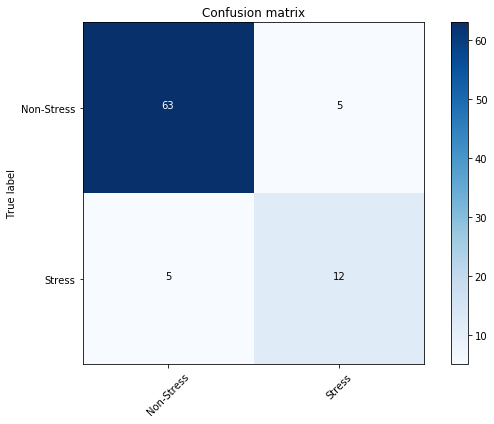

In [204]:
classes=["Non-Stress","Stress"]
result1 = np.array(labels2.iloc[:,0])
cnf = confusion_matrix(result1, result)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf, classes,
                      title='Confusion matrix')
plt.show()